In [1]:
ref = "C:/Users/Flora/Desktop/M2 Systèmes Complexes/Stage/Bioinfo/ref/"
data = "C:/Users/Flora/Desktop/M2 Systèmes Complexes/Stage/Bioinfo/LTEE-clone-curated/"
logo_analysis = "C:/Users/Flora/Desktop/M2 Systèmes Complexes/Stage/Bioinfo/logo_analysis/"

In [2]:
import os, io, random
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()

import logomaker as lm

from Bio.Seq import Seq
from Bio.Align import MultipleSeqAlignment
from Bio import AlignIO, SeqIO

import panel as pn
import panel.widgets as pnw
pn.extension()

from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Plot, Grid, Range1d
from bokeh.models.glyphs import Text, Rect
from bokeh.layouts import gridplot

import bokeh_module2 as bokeh_module
from bokeh.plotting import figure, output_file, show

In [3]:
def extract_positions(IS_name):
    '''Generates a file listing the position of insertions that occured at some point in at least
    one of the clones of one of the populations (one event can appear multiple times in the list).'''
    
    from os import listdir
    from os.path import isfile, join
    onlyfiles = [f for f in listdir(data) if isfile(join(data, f))] #listing all file names for the .gd files
    
    files = [] # creating a list that will first contain these names to be called, and later on open .gd files
    file_names = [] # list that will contain names as strings (kept as such for all the analysis)
    readlines_names = [] #list that will contain lists with the lines of each file (obtained via readlines())
    
    for i in onlyfiles: #fixing an error in the list of files (I don't know why it occurs) and filling the previously defined lists
        if len(i) < 30:
            files.append(i)
            file_names.append(i)
            readlines_names.append(i)
    
    
    for i in range(len(files)):
        files[i] = open(data+files[i],"r") #the list files becomes a list of open files
        readlines_names[i] = files[i].readlines() # the list readlines_names becomes a list of lists, with each list containing 
        # all the lines from one file
        
    insertion_positions = {} # Creating a dictionary to hold the position, orientation and duplication of/caused by the insertions
    insertion_ID = 1
    for i in range(len(file_names)): # for each file
        for line in readlines_names[i]: #we look at all the lines in the corresponding readlines_names entry
            line = line.split()
            if 'MOB' in line and IS_name in line: #if the line corresponds to a mutation linked to the IS
                insertion_positions[insertion_ID] = {'position':line[4], 'orientation':line[6], 'duplication_size':line[7]} #we add an entry for this IS position to our dictionary
                # and save the orientation and the duplication size as well
                insertion_ID += 1
                    
    
    return insertion_positions
    

In [27]:
def sort_duplicates(insertion_positions):
    
    insertion_positions2 = {}
    
    #creating a list of positions with only one occurrence per position
    list_positions = []
    for insertion_ID in insertion_positions.keys():
        list_positions.append(insertion_positions[insertion_ID]['position'])
    list_positions = set(list_positions)
    
    # for each position, retrieving the majority orientation
    for position in list_positions:
        list_orientations = []
        duplication_saved = False
        for insertion_ID in insertion_positions.keys():
            if insertion_positions[insertion_ID]['position'] == position:
                list_orientations.append(int(insertion_positions[insertion_ID]['orientation']))
                
                if not duplication_saved:
                    duplication_size = insertion_positions[insertion_ID]['duplication_size']
                
        if sum(list_orientations) > 0:
            definitive_orientation = '1'
        else: 
            definitive_orientation = '-1'
        
        insertion_positions2[int(position)] = [position, definitive_orientation, duplication_size]
    
    return insertion_positions2

In [28]:
insertion_positions = extract_positions('IS186')
insertion_positions = sort_duplicates(insertion_positions)

In [29]:
insertion_positions

{831855: ['831855', '-1', '6'],
 4524522: ['4524522', '1', '6'],
 1875544: ['1875544', '-1', '7'],
 1349566: ['1349566', '-1', '7'],
 795320: ['795320', '1', '6'],
 962005: ['962005', '1', '6'],
 2736667: ['2736667', '1', '6'],
 1391825: ['1391825', '-1', '7'],
 2944401: ['2944401', '-1', '6'],
 2522612: ['2522612', '1', '6'],
 1306344: ['1306344', '-1', '8'],
 2448493: ['2448493', '1', '6'],
 3517306: ['3517306', '1', '8'],
 1305149: ['1305149', '1', '7'],
 1875549: ['1875549', '1', '-1'],
 4616036: ['4616036', '-1', '6'],
 998325: ['998325', '1', '6'],
 1695703: ['1695703', '-1', '7'],
 337382: ['337382', '-1', '8'],
 2322340: ['2322340', '1', '6'],
 2247369: ['2247369', '1', '7'],
 330605: ['330605', '-1', '6']}

In [38]:
def generate_fasta_file(insertion_positions, fasta_name, half_seq_size = 20):
    '''Uses the dictionary generated by extract_positions() to generate a fasta file containing the sequences around the
    insertion site of each individual insertion. The fasta file is common to all clones.
    The sequence corresponds to the strand in which the IS inserted.'''
    
    ref_seq = SeqIO.read(ref+'REL606.fna', "fasta") #opening the file containing the sequence of the ancestral genome
    
    fasta_file = open(fasta_name,'w') #we open a fasta file to save the sequences of interest
    
    #for position in sort(list(set(insertion_positions))): # we use set() so as to only list each position once
    for position in reversed(sorted(insertion_positions.keys())):
        
        sense = insertion_positions[position][1]
        duplication_size = insertion_positions[position][2]
        
        seq = ref_seq[int(position)-half_seq_size:int(position)+half_seq_size+1].seq
        # sequence around the insertion site in the ancestral genome
        
        if str(sense) == '1': # for insertions that did not insert on the direct strand
            seq = seq.reverse_complement() #we take the reverse complement for the sequence


        fasta_file.write('>'+ str(position) + '_' + str(sense) + '\t' + str(duplication_size) +'\n') 
                        # we create an entry in the fasta file
        fasta_file.write( str(seq) + '\n') 
                        #we save the sequence around the insertion site in the ancestral genome

    fasta_file.close()
    

In [8]:
def get_duplications(fasta_file):
    fasta_file = open(fasta_file, 'r')
    lines = fasta_file.readlines()
    duplications = []
    for line in lines:
        if '>' in line: 
            duplication_size = line.split()[1]
            duplications.append(duplication_size)
    return duplications

In [9]:
def bokeh_alignment(fasta_file, duplications):
    '''Generates a visualization of a sequence alignment from a fasta file using bokeh.'''
    aln = AlignIO.read(fasta_file,'fasta')
    p = bokeh_module.view_alignment(aln, duplications, plot_width=900)
    pn.pane.Bokeh(p)
    show(p)

In [10]:
def make_logo(fasta_file, half_seq_size):
    with open(fasta_file, 'r') as f:
        raw_seqs = f.readlines()
    seqs = [seq.strip() for seq in raw_seqs if ('#' not in seq) and ('>') not in seq]
    counts_mat = lm.alignment_to_matrix(seqs)
    logo = lm.Logo(counts_mat, font_name = 'Arial Rounded MT Bold')
    logo.highlight_position(half_seq_size, color = 'red', alpha = 0.5)
    logo.ax.set_xticks(range(half_seq_size*2+2))
    logo.ax.set_xticklabels(range(-half_seq_size, half_seq_size+1))

In [11]:
def make_logo_info(fasta_file, half_seq_size):
    with open(fasta_file, 'r') as f:
        raw_seqs = f.readlines()
    seqs = [seq.strip() for seq in raw_seqs if ('#' not in seq) and ('>') not in seq]
    counts_mat = lm.alignment_to_matrix(seqs)
    info_mat = lm.transform_matrix(counts_mat, 
                                      from_type='counts', 
                                      to_type='information')
    logo = lm.Logo(info_mat, font_name = 'Arial Rounded MT Bold')
    logo.highlight_position(half_seq_size, color = 'red', alpha = 0.5)
    logo.ax.set_xticks(range(half_seq_size*2+2))
    logo.ax.set_xticklabels(range(-half_seq_size, half_seq_size+1))

In [35]:
insertion_positions = extract_positions('IS186')
insertion_positions = sort_duplicates(insertion_positions)
generate_fasta_file(insertion_positions, 'fasta_file_IS186.fa', half_seq_size = 15)
duplications = get_duplications('fasta_file_IS186.fa')
bokeh_alignment('fasta_file_IS186.fa', duplications)

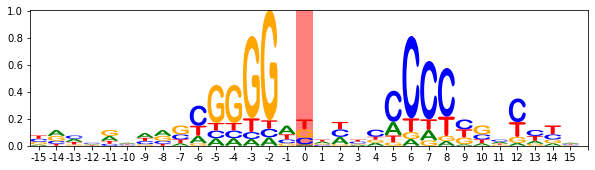

In [36]:
make_logo_info('fasta_file_IS186.fa', 15)

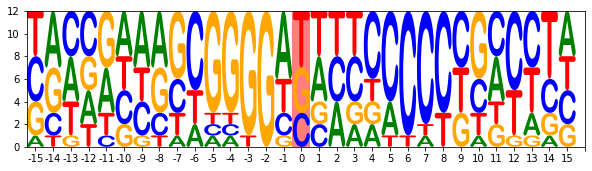

In [37]:
make_logo('fasta_file_IS186.fa', 15)

In [15]:
insertion_positions = extract_positions('IS150')
insertion_positions = sort_duplicates(insertion_positions)
generate_fasta_file(insertion_positions, 'fasta_file_IS150.fa', half_seq_size = 15)
duplications = get_duplications('fasta_file_IS150.fa')
bokeh_alignment('fasta_file_IS150.fa', duplications)

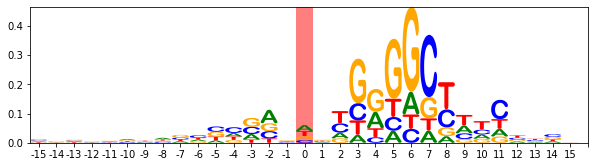

In [16]:
make_logo_info('fasta_file_IS150.fa', 15)

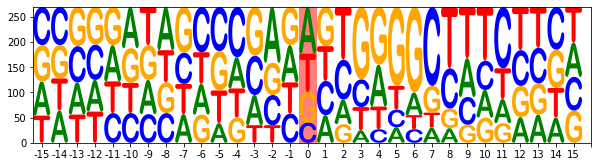

In [17]:
make_logo('fasta_file_IS150.fa', 15)

In [18]:
insertion_positions = extract_positions('IS1')
insertion_positions = sort_duplicates(insertion_positions)
generate_fasta_file(insertion_positions, 'fasta_file_IS1.fa', half_seq_size = 15)
duplications = get_duplications('fasta_file_IS1.fa')
bokeh_alignment('fasta_file_IS1.fa', duplications)

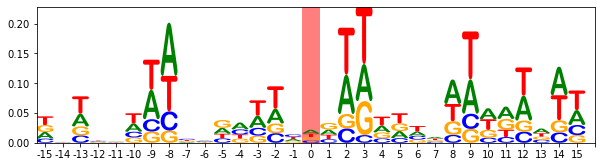

In [19]:
make_logo_info('fasta_file_IS1.fa', 15)

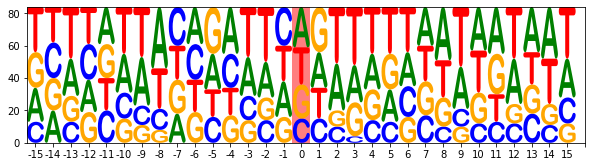

In [20]:
make_logo('fasta_file_IS1.fa', 15)